# Toy Example

In [3]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch

In [4]:
class ToyExample:
    def __init__(self, as_, lr, iters, k, func_type):
        self.as_ = as_
        self.lr = lr
        self.iters = iters
        self.k = k
        
        self.rng = np.random.default_rng()
        if func_type=='quad':
            self.func = self.quad_func
        elif func_type=='quad_duo':
            self.func = self.quad_duo_func
            if len(as_.shape)!=2:
                raise ValueError('as_ should have 2 dimensional shape')


    def rand_init_x(self, range=(-10, 10)):
        x = torch.distributions.uniform.Uniform(range[0], range[1]).sample()
        x.requires_grad_(True)
        return x
    
    def expectation_a(self):
        return self.as_.sum()/len(self.as_)
    
    def quad_func(self, x, stochastic = True):    
        if stochastic:
            a_ = self.rng.choice(self.as_, size=1)[0]
        else:
            a_ = self.expectation_a()

        y = x*x*a_/self.k
        return y, a_
    
    def quadDuo_subFunc(self, sub_as_, x):
        f1 = sub_as_[0]*(x**2)/self.k
        f2 = sub_as_[1]*((x-1)**2)/self.k

        if f1<f2:
            return f1, sub_as_[0]
        else:
            return f2, sub_as_[1]
    
    def quad_duo_func(self, x, stochastic = True):
        if stochastic:
            c = self.rng.choice([0, 1], size=1)[0]
            y, a_ = self.quadDuo_subFunc(self.as_[c], x)
        else:
            y1, a1 = self.quadDuo_subFunc(self.as_[0], x)
            y2, a2 = self.quadDuo_subFunc(self.as_[1], x)
            y = (y1 + y2)/2
            a_ = (a1 + a2)/2

        return y, a_
        
    
    def optimize(self, x, stochastic = True):
        self.x_prog = [x.item()]
        self.f_prog = [self.func(x, False)[0].item()]
        self.dynamics_rv_prog = []
        # self.grad_prog = []
        self.a_prog = []
        

        for _ in tqdm(range(self.iters)):
            y, a_ = self.func(x, stochastic=stochastic)
            y.backward()

            with torch.no_grad():
                # print(x.grad == x*a_)
                x.copy_(x - self.lr*x.grad)

                # dynamics_rv realization
                dynamics_rv = 1 - (2*self.lr*a_)/self.k
                self.dynamics_rv_prog.append(dynamics_rv)
                self.a_prog.append(a_)
                # self.grad_prog.append(x.grad.item())
                x.grad.zero_()

            self.x_prog.append(x.item())
            self.f_prog.append(self.func(x, False)[0].item())

        return x.item()
    
    def plot(self):
        # x_ax = np.linspace(-10, 10, 100)
        x_ax = np.linspace(-1, 1.5, 100)
        y_ax = np.array([self.func(x, stochastic=False)[0] for x in x_ax])
        plt.plot(x_ax, y_ax)

        diff_x = np.diff(self.x_prog)
        diff_f = np.diff(self.f_prog)
        plt.quiver(self.x_prog[:-1], self.f_prog[:-1], diff_x, diff_f, angles = 'xy', scale_units='xy', scale=1)
       
        plt.scatter(self.x_prog, self.f_prog, c = np.arange(len(self.x_prog)))
        plt.colorbar(label='iters')
        plt.show()


100%|██████████| 100/100 [00:00<00:00, 969.97it/s]


optimised x: -6.5648909351085855e-37


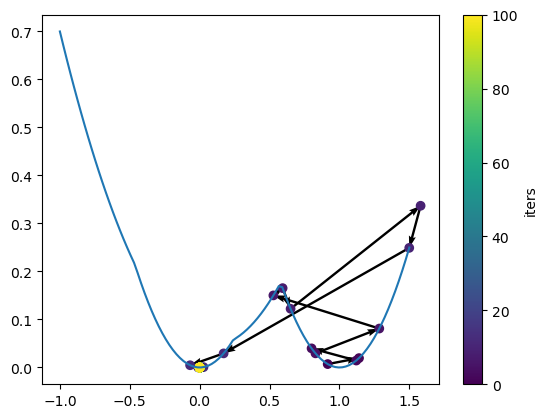

In [5]:
lr = 0.7
iters = 100
k = 1

# as_ = np.array([0.1, 1.9])
# as_ = np.array([1, 1])
as_ = np.array([[1, 0.1], [1, 1.9]])

# toy = ToyExample(as_, lr, iters, k, 'quad')
# x_opt = toy.optimize(toy.rand_init_x())

toy = ToyExample(as_, lr, iters, k, 'quad_duo')
x_opt = toy.optimize(toy.rand_init_x(range=(1-(1e-1), 1+(1e-1))), True)
# x_opt = toy.optimize(toy.rand_init_x(range=(-(1e-1), +(1e-1))), False)


print('optimised x:', x_opt)
toy.plot()


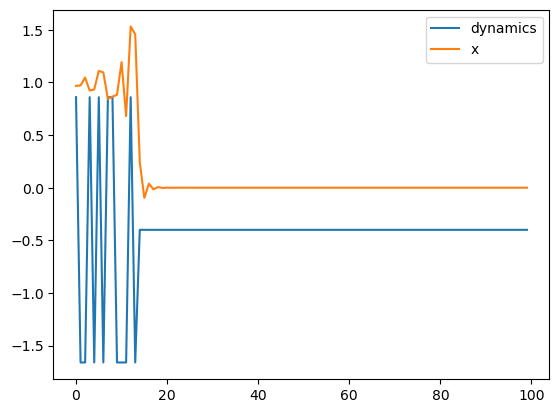

In [17]:
plt.plot(toy.dynamics_rv_prog, label = 'dynamics')
# plt.plot(toy.grad_prog)
plt.plot(toy.x_prog[:-1], label = 'x')
# plt.plot(toy.a_prog, label = 'a')
plt.legend()


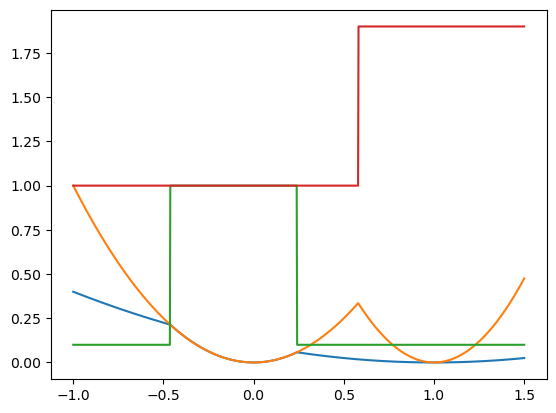

In [6]:
x_ax = np.linspace(-1, 1.5, 1000)
f1_ax = [toy.quadDuo_subFunc(as_[0], x)[0].item() for x in x_ax]
f2_ax = [toy.quadDuo_subFunc(as_[1], x)[0].item() for x in x_ax]

a_1 = [toy.quadDuo_subFunc(as_[0], x)[1] for x in x_ax]
a_2 = [toy.quadDuo_subFunc(as_[1], x)[1] for x in x_ax]


plt.plot(x_ax, f1_ax)
plt.plot(x_ax, f2_ax)
plt.plot(x_ax, a_1)
plt.plot(x_ax, a_2)


In [ ]:
# check stability near 1
as_ = np.array([0.1, 1.9])

def calc_dynamic_value(a_, lr, k):
    return 1 - (2*lr*a_/k)

dynamics_rv = np.array([calc_dynamic_value(a_, lr, k) for a_ in as_])
dynamics_rv_square = np.square(dynamics_rv)


tensor(-7.3786, requires_grad=True)


100%|██████████| 100/100 [00:00<00:00, 2699.85it/s]


np.float64(1.7475999999999994)

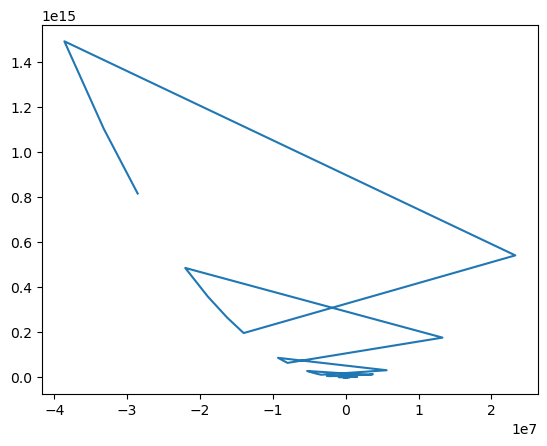

In [ ]:

rng = np.random.default_rng()


def expectation_a_square(as_):
    return np.square(as_).sum()/len(as_)

def var_a(as_):
    '''this is nothing but s^2'''
    return expectation_a_square(as_) - expectation_a(as_)**2



def func(x, as_, k = 2, stochastic=True):    
    if stochastic:
        a_ = rng.choice(as_, size=1)[0]
    else:
        a_ = expectation_a(as_)

    y = x*x*a_/k
    return y



x = torch.distributions.uniform.Uniform(-10, 10).sample()
x.requires_grad_(True)

print(x)




x_prog = [x.item()]
f_prog = [func(x, as_, k, stochastic=False).item()]

for _ in tqdm(range(iters)):
    y = func(x, as_, k, stochastic=True)
    y.backward()

    with torch.no_grad():
        # print(x.grad == x*a_)
        x.copy_(x-lr*x.grad)
        x.grad.zero_()

    x_prog.append(x.item())
    f_prog.append(func(x, as_, k, stochastic=False).item())



x_prog = np.array(x_prog)
f_prog = np.array(f_prog)

plt.plot(x_prog, f_prog)


dynamics_rv_square.mean()